In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm

from lifelines.plotting import plot_lifetimes
from numpy.random import uniform, exponential

from sksurv.nonparametric import kaplan_meier_estimator
from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter
from lifelines import CoxPHFitter

from sksurv.preprocessing import OneHotEncoder

from sklearn.preprocessing import LabelEncoder

from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

import seaborn as sns

# import altair as alt

# pd.set_option('mode.chained_assignment', None)

In [2]:

# Use to restrict x-axis when displaying time-related data
DATE_RANGE = (pd.to_datetime('2016-09'), pd.to_datetime('2019-06-01'))

FIG_SIZE = (10, 6)
PALETTE = sns.color_palette()
plt.rcParams['figure.figsize'] = FIG_SIZE

def savefig(fig, name):
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )

### Load Dataset

In [79]:
index = pd.date_range('1/1/2000', periods=9, freq='min')
series = pd.Series(range(9), index=index)
series

2000-01-01 00:00:00    0
2000-01-01 00:01:00    1
2000-01-01 00:02:00    2
2000-01-01 00:03:00    3
2000-01-01 00:04:00    4
2000-01-01 00:05:00    5
2000-01-01 00:06:00    6
2000-01-01 00:07:00    7
2000-01-01 00:08:00    8
Freq: T, dtype: int64

In [83]:
series = series.resample('30s').bfill()[0:5]

In [84]:
series

2000-01-01 00:00:00    0
2000-01-01 00:00:30    1
2000-01-01 00:01:00    1
2000-01-01 00:01:30    2
2000-01-01 00:02:00    2
Freq: 30S, dtype: int64

In [76]:
df = pd.read_csv("../data/repoissuedata_v3.csv.gz", compression='gzip')
df

,message,filepath,line,column,kind,snippet,end_column,file_hash,repository,commit_hash,...,probably_workflow,valid_workflow,lines_count,commit_year,commit_mon_year,next_commit_hash,status,error_count,time_lapse,Rule
0,"undefined variable ""go"". available variables a...",../data-raw/data-v2/workflows/e4d71b496daf9107...,19,30,expression,working-directory: ${{ go.module-path }}...,43,e4d71b496daf910760a618e45146cb4f69a8894ae1212b...,filhodanuvem---gitql,cc252e32322cbf19984cc0881d5c3961a8be6b65,...,True,True,19,2019,2019-08,d936e682f76c93079bdcdc369309e8f60db1645f,closed,1.0,0 days 00:00:00,Bugs - Blocker
1,"undefined variable ""go"". available variables a...",../data-raw/data-v2/workflows/e4d71b496daf9107...,15,30,expression,working-directory: ${{ go.module-path }}...,43,e4d71b496daf910760a618e45146cb4f69a8894ae1212b...,filhodanuvem---gitql,cc252e32322cbf19984cc0881d5c3961a8be6b65,...,True,True,19,2019,2019-08,d936e682f76c93079bdcdc369309e8f60db1645f,closed,0.0,0 days 00:00:00,Bugs - Blocker
2,"label ""macOS-10.14"" is unknown. available labe...",../data-raw/data-v2/workflows/07395e47af224606...,38,14,runner-label,runs-on: macOS-10.14\n ^~~~~~~...,24,07395e47af224606fed1ecad9fc9d85ab0c7ae4d40d1b2...,filhodanuvem---gitql,d936e682f76c93079bdcdc369309e8f60db1645f,...,True,True,99,2019,2019-10,875d794ca2227ad5bfddc8a1e33cb9e932a910af,open,1.0,80 days 01:57:51,Bugs - Blocker
3,"label ""macOS-10.14"" is unknown. available labe...",../data-raw/data-v2/workflows/0f5da2ee3c5f0df7...,44,14,runner-label,runs-on: macOS-10.14\n ^~~~~~~...,24,0f5da2ee3c5f0df7571dc9f194b3e1162c316a573a41ee...,filhodanuvem---gitql,875d794ca2227ad5bfddc8a1e33cb9e932a910af,...,True,True,105,2019,2019-11,beebd12c9828f68db27cf0c94901a2597625ab66,open,0.0,94 days 22:54:55,Bugs - Blocker
4,"label ""macOS-10.14"" is unknown. available labe...",../data-raw/data-v2/workflows/433a0991901ed919...,41,14,runner-label,runs-on: macOS-10.14\n ^~~~~~~...,24,433a0991901ed91940295611dad0f47e644f9b6f0d43e4...,filhodanuvem---gitql,beebd12c9828f68db27cf0c94901a2597625ab66,...,True,True,93,2020,2020-10,NaN,closed,1.0,422 days 21:54:34,Bugs - Blocker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858698,"property ""versioning"" is not defined in object...",../data-raw/data-v2/workflows/37db5a30e8968384...,30,35,expression,run: |,35,37db5a30e8968384dada935e09695e7835ee88c52225b7...,rospino74---quizlet-bypass,8aa9b8a890f8300ec727f06671e3b848713e5dec,...,True,True,70,2023,2023-10,a4fcc7a18597970ea6a6501ad8084a43c65d480f,open,0.0,0 days 00:00:00,Bugs - Blocker
858699,"property ""versioning"" is not defined in object...",../data-raw/data-v2/workflows/d695aba7f39862cf...,30,35,expression,run: |,35,d695aba7f39862cf7573a7c007fc5a8e42230184f75601...,rospino74---quizlet-bypass,a4fcc7a18597970ea6a6501ad8084a43c65d480f,...,True,True,70,2023,2023-10,NaN,closed,1.0,0 days 00:00:01,Bugs - Blocker
858700,"property ""versioning"" is not defined in object...",../data-raw/data-v2/workflows/d695aba7f39862cf...,13,21,expression,new-tag: v${{ steps.versioning.outputs.n...,52,d695aba7f39862cf7573a7c007fc5a8e42230184f75601...,rospino74---quizlet-bypass,a4fcc7a18597970ea6a6501ad8084a43c65d480f,...,True,True,70,2023,2023-10,NaN,closed,0.0,0 days 00:00:01,Bugs - Blocker
858701,"label ""domestic"" is unknown. available labels ...",../data-raw/data-v2/workflows/c67c0c6045526270...,9,28,runner-label,"runs-on: [self-hosted, domestic]\n ...",36,c67c0c60455262703d673a4ee96c93bc309715eb154ad9...,cloudwego---cloudwego.github.io,060e6c313139189c91d0043ab1c44df70052aa33,...,True,True,40,2023,2023-10,NaN,closed,1.0,0 days 00:00:00,Bugs - Blocker


In [4]:
# fig, ax = plt.subplots(figsize=(10, 6))

# # gettinig the number of issues per month in the year
# no_of_issue = (
#     df
# #     .drop_duplicates(['repository', 'file_path', 'commit_mon_year'], keep='last')
#     .groupby(['commit_mon_year'], sort=True)
#     .agg({'committed_date': 'count'})
#     .rename(columns={'committed_date': 'no_of_issue'})
# )

# # converting the date to numeric
# dates = mdates.date2num(no_of_issue.index)

# ax.plot(dates, no_of_issue['no_of_issue'])
# ax.set_title('Issue in Workflow files in each month of the year')
# ax.set_xlabel('Date')
# ax.set_ylabel('Issue')


# # Add the grid
# plt.grid(True)

# # Format x-axis labels as dates
# date_form = mdates.DateFormatter('%b, %Y')
# ax.xaxis.set_major_formatter(date_form)

# # ax.xaxis.set_major_locator(half_year_locator)

# plt.gcf().autofmt_xdate()

# plt.show()

## Research Question 

Q1- Which error messages combinations are more frequent than the others?  

Q2- How long it take to resolve the error message?

Q3- How much time lapse between the commits? Is there is a noticeable pattern in commit frequency ?

Q4- Do the commits made outside of the working hour has the higher error count? not interested

Q5- Are there any seasonal or temporal trends in the frequency of the introduction of the error over time? not interested


## Exploratory Data Analysis

checking the number of code quality issue in each month of the year

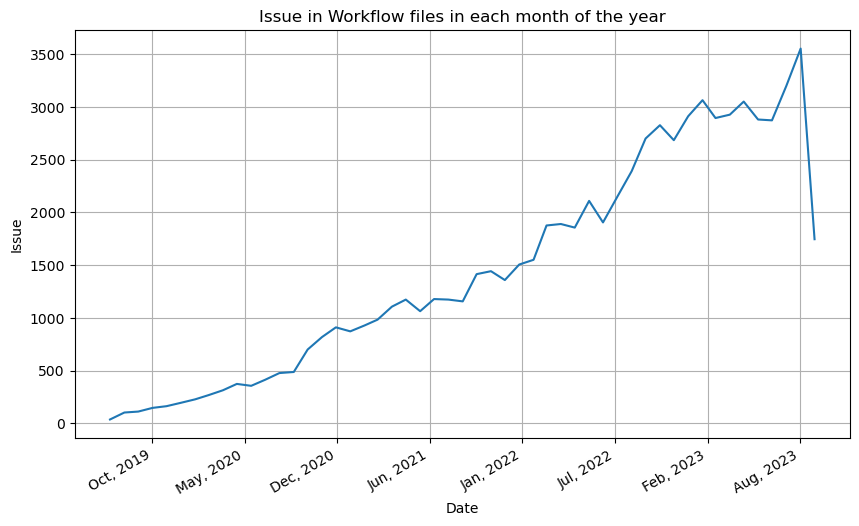

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))

# gettinig the number of issues per month in the year
no_of_issue = df.groupby('commit_mon_year')['message'].nunique().reset_index(name='unique_message_count')

# converting the date to numeric
dates = mdates.date2num(no_of_issue.commit_mon_year.values)

ax.plot(dates, no_of_issue['unique_message_count'].values)
ax.set_title('Issue in Workflow files in each month of the year')
ax.set_xlabel('Date')
ax.set_ylabel('Issue')


# Add the grid
plt.grid(True)

# Format x-axis labels as dates
date_form = mdates.DateFormatter('%b, %Y')
ax.xaxis.set_major_formatter(date_form)

# ax.xaxis.set_major_locator(half_year_locator)

plt.gcf().autofmt_xdate()

plt.show()

In [6]:
df['kind'].value_counts()

deprecated-commands    341957
expression             273202
runner-label           125748
workflow-call           44395
matrix                  21357
events                  15626
action                  13340
syntax-check            12075
glob                     6614
job-needs                2677
id                        730
shell-name                610
env-var                   366
yaml-syntax                 6
Name: kind, dtype: int64

In [7]:
df.describe()

,line,column,end_column,authored_date,lines_count,commit_year,error_count
count,858703.000000,858703.000000,858703.000000,8.587030e+05,858703.000000,858703.000000,858703.000000
mean,233.634059,29.082004,39.788989,1.648612e+09,471.350255,2021.749662,6.949959
std,492.223324,70.817336,71.654706,3.126465e+07,850.795232,1.023047,23.023052
min,1.000000,0.000000,0.000000,1.422264e+09,5.000000,2019.000000,0.000000
25%,37.000000,14.000000,14.000000,1.624421e+09,100.000000,2021.000000,1.000000
50%,86.000000,14.000000,25.000000,1.652727e+09,205.000000,2022.000000,2.000000
75%,207.000000,28.000000,47.000000,1.674689e+09,436.000000,2023.000000,6.000000
max,11780.000000,8500.000000,8500.000000,1.697111e+09,12520.000000,2023.000000,317.000000


In [8]:
print("The number of unique messages: {}".format(df['message'].nunique()))

The number of unique messages: 24847


checking the number of code quality issues for each kind of code quality issue in workflows

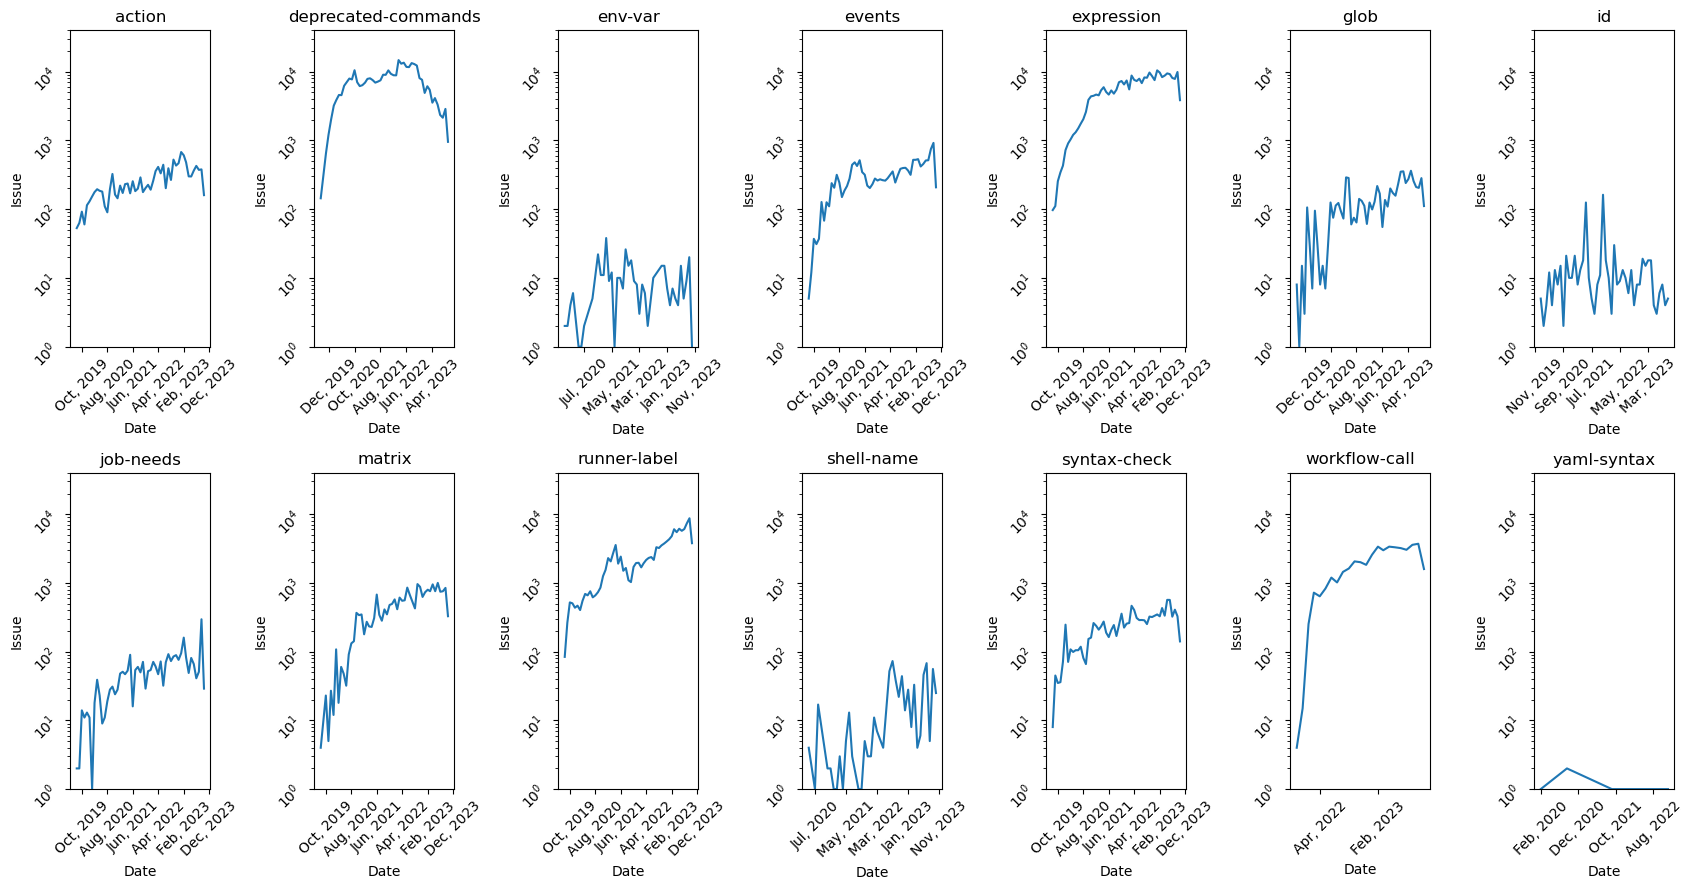

In [74]:
no_issue_kind = (
    df
    .groupby(['kind','commit_mon_year'], as_index=False)
    .agg({'committed_date': 'count'})
    .rename(columns={'committed_date': 'no_of_issue'})
)

plt.rcParams.update({'figure.figsize':(17,9), 'figure.dpi':100})

kinds = no_issue_kind['kind'].unique()

def plotnew(ax, kind):
    data = no_issue_kind[no_issue_kind['kind'] == kind]
    ax.plot(mdates.date2num(data.commit_mon_year.values), data['no_of_issue'].values)
    ax.set_xlabel('Date')
    ax.set_ylabel('Issue')
   
    ax.set_title(kind)
    
        # Format x-axis labels as dates
    date_form = mdates.DateFormatter('%b, %Y')
    ax.xaxis.set_major_formatter(date_form)

    half_year_locator = mdates.MonthLocator(interval=10)
#     monthly_locator = mdates.MonthLocator()
    
    ax.xaxis.set_major_locator(half_year_locator)
#     ax.xaxis.set_minor_locator(monthly_locator)
    ax.set_ylim(1, 40000)
    ax.set_yscale('log')
    
    ax.tick_params(labelrotation=45)

   
    
    
fig, axes = plt.subplots(nrows=2, ncols=7)

for i, ax in enumerate(axes.flat):  # Start from 1 to 4 (ax1 to ax16)
    plotnew(ax, kinds[i])
    
# plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

checking the number of code quality issues for each rule

In [10]:
df['Rule'].value_counts()

Bugs - Blocker        443107
Code smells           356328
Syntax Error           34028
Bugs - Non Blocker     25234
Yaml Syntax                6
Name: Rule, dtype: int64

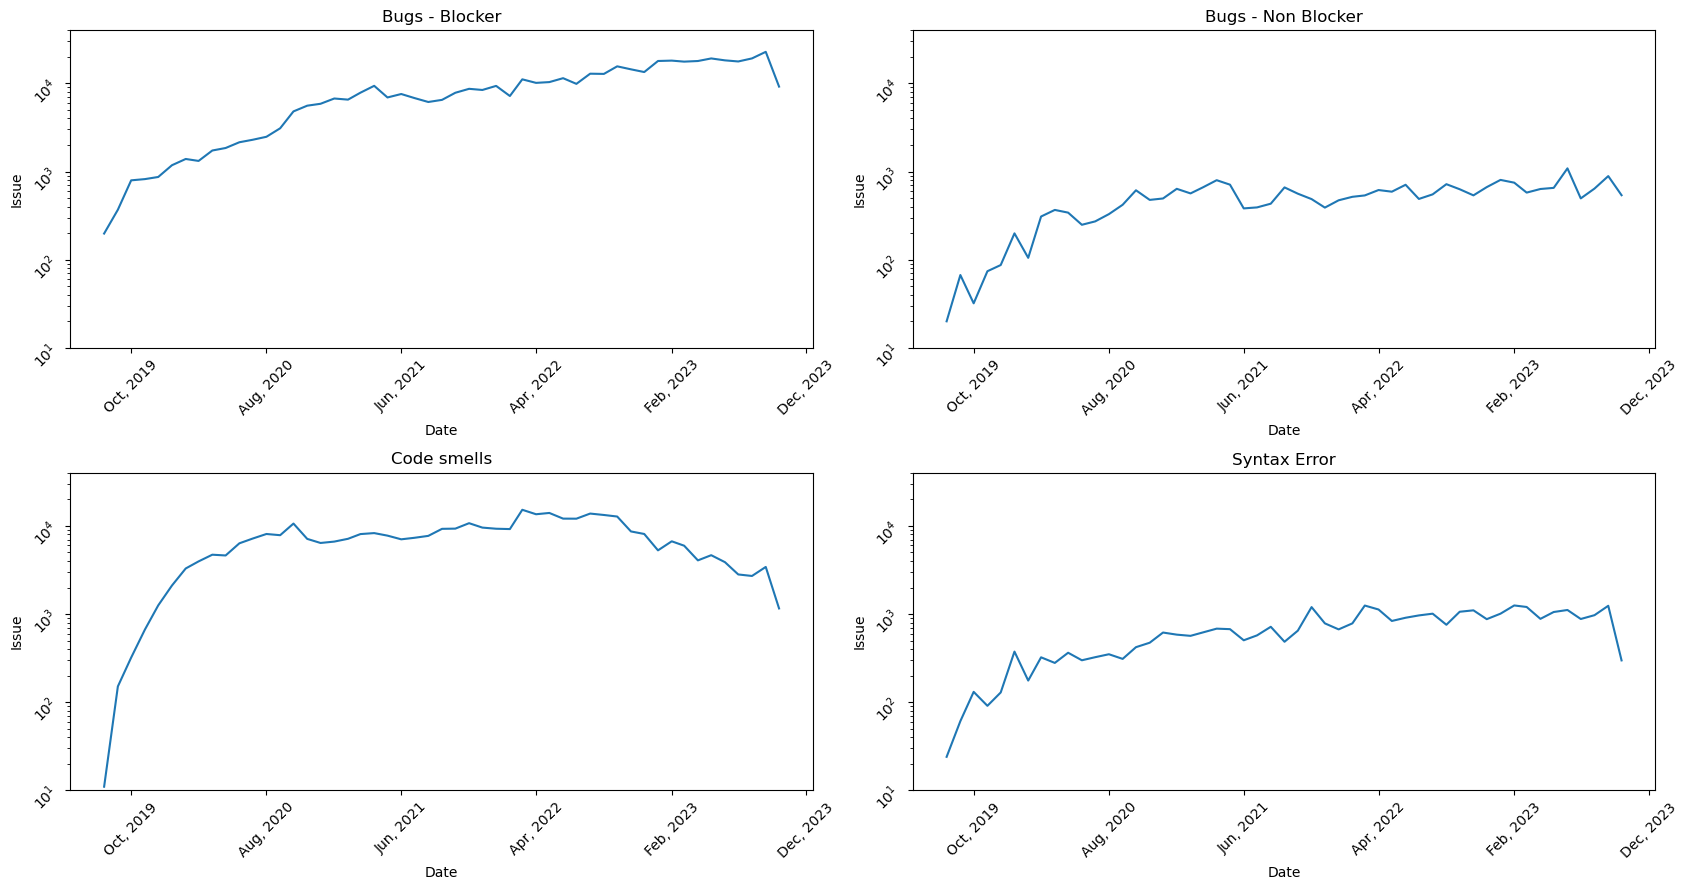

In [11]:
no_issue_rule = (
    df
    .groupby(['Rule','commit_mon_year'], as_index=False)
    .agg({'committed_date': 'count'})
    .rename(columns={'committed_date': 'no_of_issue'})
)

plt.rcParams.update({'figure.figsize':(17,9), 'figure.dpi':100})

rule = no_issue_rule['Rule'].unique()

def plot_unique_rule(ax, rule):
    data = no_issue_rule[no_issue_rule['Rule'] == rule]
    ax.plot(mdates.date2num(data.commit_mon_year.values), data['no_of_issue'].values)
    ax.set_xlabel('Date')
    ax.set_ylabel('Issue')

    
    ax.set_yscale('log')
    
    ax.set_title(rule)
    
        # Format x-axis labels as dates
    date_form = mdates.DateFormatter('%b, %Y')
    ax.xaxis.set_major_formatter(date_form)

    half_year_locator = mdates.MonthLocator(interval=10)
#     monthly_locator = mdates.MonthLocator()
    
    ax.xaxis.set_major_locator(half_year_locator)
#     ax.xaxis.set_minor_locator(monthly_locator)
    ax.set_ylim(10, 40000)
    ax.set_yscale('log')
    ax.tick_params(labelrotation=45)

   
    
    
fig, axes = plt.subplots(nrows=2, ncols=2)

for i, ax in enumerate(axes.flat):  # Start from 1 to 4 (ax1 to ax16)
    plot_unique_rule(ax, rule[i])
    
# plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [12]:
df['commit_year'].value_counts()

2022    299236
2023    235708
2021    203015
2020    114573
2019      6171
Name: commit_year, dtype: int64

The data is:[  3051  33767  89439 138738 178112]
The data is:[ 280 4177 6677 7033 7067]
The data is:[  2404  72315  98862 142121  40626]
The data is:[  436  4311  8036 11342  9903]


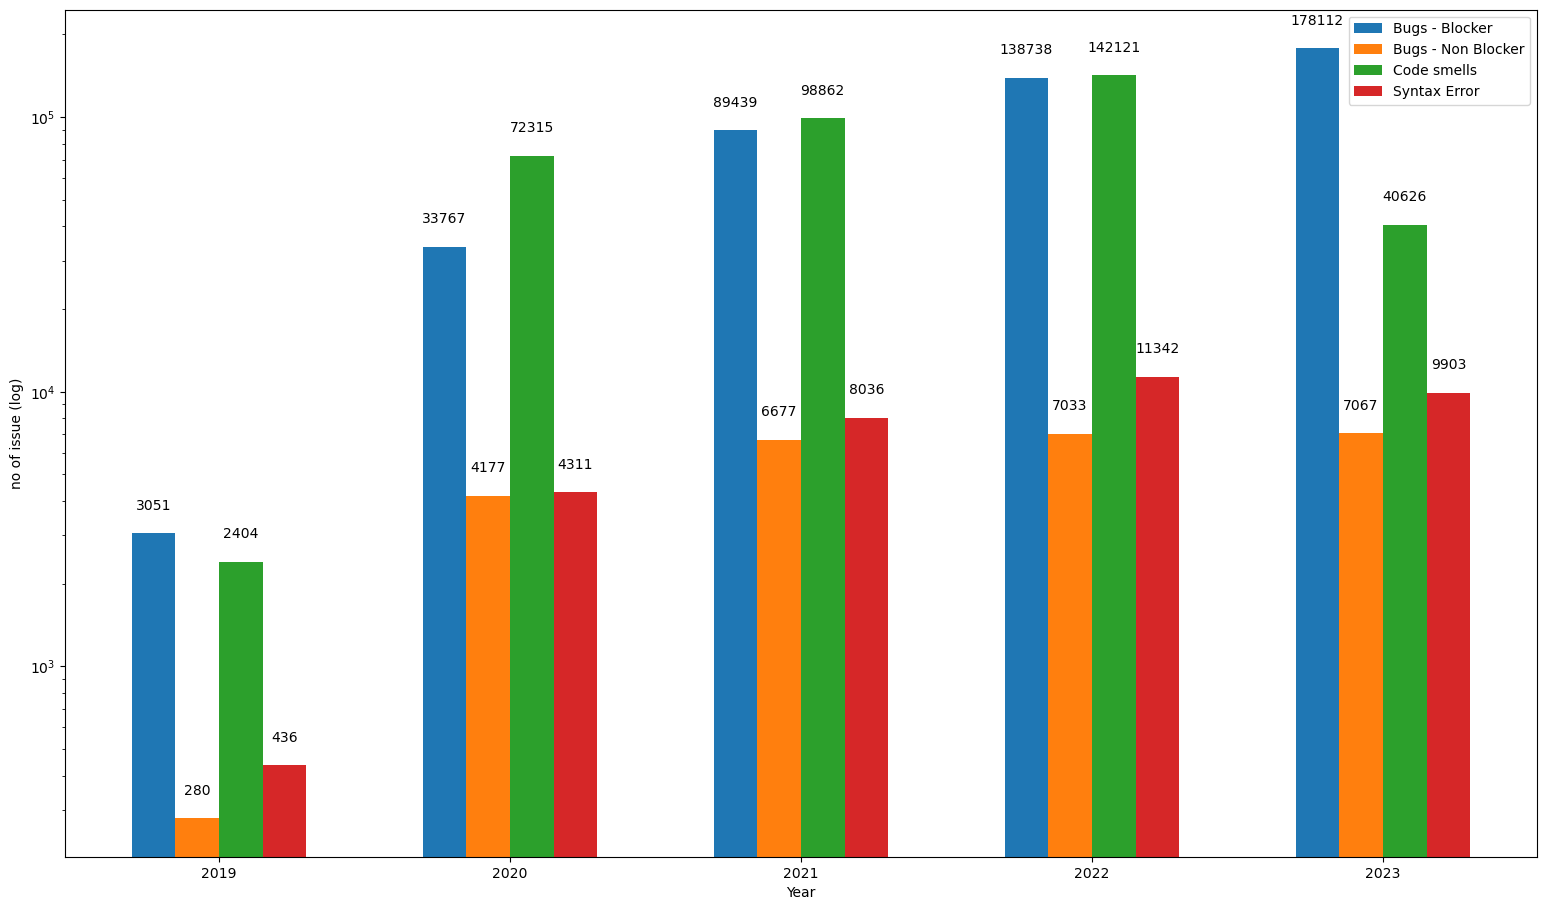

In [13]:
no_issue_per_year = (
    df
    .groupby(['Rule', 'commit_year'], as_index=False)
    .agg({'commit_hash': 'count'})
    .rename(columns={'commit_hash': 'issue'})
)

N = 5
ind = np.arange(N)  
width = 0.15
plt.rcParams.update({'figure.figsize':(19,11), 'figure.dpi':100})  

bars = []
for i, rule in enumerate(no_issue_per_year['Rule'].unique()):
    if rule == 'Yaml Syntax':
     continue
    data = no_issue_per_year[no_issue_per_year['Rule'] == rule]
    print("The data is:{}".format(data['issue'].values))
    bars.append(plt.bar(ind + width * i, data['issue'].values, width))
    plt.bar_label(bars[i], padding = 15)
    
plt.xlabel("Year")
plt.ylabel('no of issue (log)')
plt.yscale('log')
# plt.title("Players Score")

plt.xticks(ind + width * (N - 3.5), no_issue_per_year['commit_year'].unique())

legend_labels = no_issue_per_year['Rule'].unique()
plt.legend(bars, legend_labels)

plt.show()

In [14]:
no_issue_per_year

,Rule,commit_year,issue
0,Bugs - Blocker,2019,3051
1,Bugs - Blocker,2020,33767
2,Bugs - Blocker,2021,89439
3,Bugs - Blocker,2022,138738
4,Bugs - Blocker,2023,178112
5,Bugs - Non Blocker,2019,280
6,Bugs - Non Blocker,2020,4177
7,Bugs - Non Blocker,2021,6677
8,Bugs - Non Blocker,2022,7033
9,Bugs - Non Blocker,2023,7067


## Checking Feature Corelation

Converting the value of the features into numeric values

In [16]:
objects_cols = df.select_dtypes(include = ['object']).columns
df_cor = df.loc[:, ~df.columns.isin(['valid_yaml', 'probably_workflow', 'valid_workflow'])]
for col in objects_cols:
    df_cor[col] = np.uint8(LabelEncoder().fit_transform(df_cor[col]))

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_15568/2619650586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cor[col] = np.uint8(LabelEncoder().fit_transform(df_cor[col]))
/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_15568/2619650586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cor[col] = np.uint8(LabelEncoder().fit_transform(df_cor[col]))
/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_15568/2619650586.py:4: SettingWithCopyWarning: 
A value is trying

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_15568/2619650586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cor[col] = np.uint8(LabelEncoder().fit_transform(df_cor[col]))
/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_15568/2619650586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cor[col] = np.uint8(LabelEncoder().fit_transform(df_cor[col]))


In [17]:
df_cor.corr().style.background_gradient(axis=None, vmin=-1, vmax=1, ).format("{:0.2f}")

,message,filepath,line,column,kind,snippet,end_column,file_hash,repository,commit_hash,author_name,author_email,committer_name,committer_email,committed_date,authored_date,file_path,previous_file_path,previous_file_hash,change_type,lines_count,commit_year,commit_mon_year,next_commit_hash,status,error_count,time_lapse,Rule
message,1.00,0.00,0.00,0.10,0.56,0.29,0.17,0.00,0.01,-0.00,0.00,0.01,-0.00,0.03,-0.00,0.17,-0.00,-0.02,0.01,-0.01,-0.00,0.17,0.17,0.01,-0.18,0.10,-0.01,-0.54
filepath,0.00,1.00,-0.01,0.00,0.00,-0.00,0.00,1.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.01,-0.00,-0.00,-0.00,0.00,0.01,0.01,-0.00
line,0.00,-0.01,1.00,0.03,-0.01,-0.01,0.05,-0.01,0.01,0.03,-0.04,0.01,0.11,0.02,0.01,0.11,0.07,-0.14,0.00,0.06,0.84,0.11,0.11,-0.01,0.01,0.41,0.02,-0.06
column,0.10,0.00,0.03,1.00,0.02,-0.01,0.98,0.00,0.01,-0.00,0.01,0.01,0.00,-0.00,-0.01,0.03,-0.01,-0.00,-0.00,0.01,0.02,0.03,0.03,0.00,-0.02,0.03,0.00,-0.12
kind,0.56,0.00,-0.01,0.02,1.00,0.31,0.11,0.00,0.03,-0.01,-0.01,-0.01,0.03,0.04,0.01,0.32,0.01,-0.04,0.01,-0.02,-0.01,0.31,0.32,0.00,-0.19,0.09,0.00,-0.59
snippet,0.29,-0.00,-0.01,-0.01,0.31,1.00,0.05,-0.00,0.01,-0.01,0.00,0.01,-0.01,0.03,0.00,0.10,0.02,-0.04,0.00,-0.01,-0.03,0.10,0.10,0.01,-0.09,0.06,-0.00,-0.33
end_column,0.17,0.00,0.05,0.98,0.11,0.05,1.00,0.00,0.02,-0.00,0.01,0.01,0.01,-0.00,-0.01,0.08,0.00,-0.01,0.00,0.00,0.04,0.08,0.08,0.00,-0.05,0.07,0.00,-0.23
file_hash,0.00,1.00,-0.01,0.00,0.00,-0.00,0.00,1.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.01,-0.00,-0.00,-0.00,0.00,0.01,0.01,-0.00
repository,0.01,-0.00,0.01,0.01,0.03,0.01,0.02,-0.00,1.00,-0.01,0.03,-0.04,0.02,-0.03,0.00,0.02,0.04,-0.03,-0.00,0.01,0.01,0.02,0.02,0.00,0.01,0.03,0.00,-0.05
commit_hash,-0.00,0.00,0.03,-0.00,-0.01,-0.01,-0.00,0.00,-0.01,1.00,-0.02,0.01,0.01,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.04,-0.00,0.00,0.00,0.00,0.02,-0.00,0.01


checking the relationship of error count and lines count as from the above coorelation plot they are bit corelated

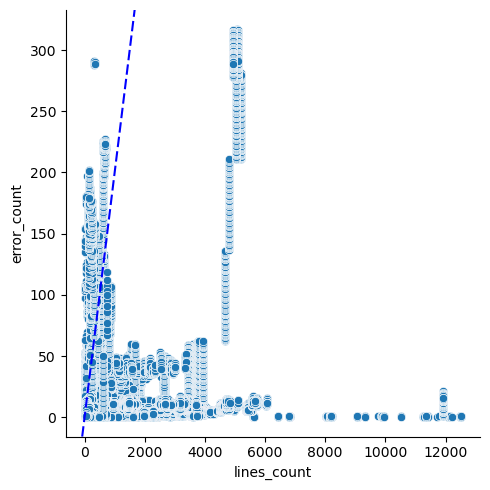

In [77]:
g = sns.relplot(data=df, x="lines_count", y="error_count")
g.ax.axline(xy1=(10, 2), slope=.2, color="b", dashes=(5, 2))

## Combination of messages w.r.t error count

In [34]:
(df['error_count'].value_counts(normalize = True) * 100)

1.0      23.250297
2.0      14.635211
0.0      13.302853
3.0       9.291804
4.0       6.828671
           ...    
316.0     0.000582
183.0     0.000582
206.0     0.000582
205.0     0.000582
317.0     0.000116
Name: error_count, Length: 318, dtype: float64

checking the combination of the messages with the error count of 3

In [37]:
error_count_2 = df[df['error_count'] == 2]

message_combinations = error_count_2[['message', 'Rule']].value_counts().reset_index(name='count')

message_combinations.head(20)

# print("The length of the message combinations with 2 error messages: ", len(message_combinations))

,message,Rule,count
0,"workflow command ""set-output"" was deprecated. ...",Code smells,48398
1,"property ""workspace"" is not defined in object ...",Bugs - Blocker,10679
2,"workflow command ""set-env"" was deprecated. use...",Code smells,5849
3,"label ""ubuntu-16.04"" is unknown. available lab...",Bugs - Blocker,2097
4,"workflow command ""add-path"" was deprecated. us...",Code smells,1799
5,"property ""node-version"" is not defined in obje...",Bugs - Blocker,1523
6,property access of object must be type of stri...,Bugs - Non Blocker,1283
7,"""github.head_ref"" is potentially untrusted. av...",Code smells,842
8,character '\' is invalid for branch and tag na...,Bugs - Non Blocker,834
9,"property ""python-version"" is not defined in ob...",Bugs - Blocker,766


checking the combination of the messages with the error count of 2

In [65]:
error_count_1 = df[df['error_count'] == 1]

message_combinations = error_count_1[['message', 'Rule']].value_counts().reset_index(name='count')

message_combinations.head(20)
# print("The length of the message combinations with 2 error messages: ", len(message_combinations))

,message,Rule,count
0,"workflow command ""set-output"" was deprecated. ...",Code smells,85210
1,"property ""workspace"" is not defined in object ...",Bugs - Blocker,20238
2,"workflow command ""set-env"" was deprecated. use...",Code smells,9712
3,"label ""ubuntu-16.04"" is unknown. available lab...",Bugs - Blocker,6157
4,"workflow command ""add-path"" was deprecated. us...",Code smells,2989
5,property access of object must be type of stri...,Bugs - Non Blocker,2923
6,"property ""node-version"" is not defined in obje...",Bugs - Blocker,2578
7,"property ""python-version"" is not defined in ob...",Bugs - Blocker,1764
8,"property ""os"" is not defined in object type {}",Bugs - Blocker,1458
9,got unexpected character '\u00a0' while lexing...,Syntax Error,1314


checking the combination of the messages with the error count of 1

In [48]:
error_count_0 = df[df['error_count'] == 0]

message_combinations = error_count_0[['message', 'Rule']].value_counts().reset_index(name='count')

message_combinations.head(20)

# print("The length of the message combinations with 1 error messages: ", len(message_combinations))

The length of the message combinations with 1 error messages:  4354


In [52]:
# Step 1: Filter the dataset
# filtered_df = df[df['error_count'] == 1]

# # Step 2: Create a frequency table for combinations of 'message'
# message_combinations = pd.crosstab(filtered_df['message'], filtered_df['message'])

# Step 3: Create a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(message_combinations_freq, cmap='coolwarm', annot=True, fmt='g')
# plt.title('Combinations of Messages for Error Count = 2')
# plt.xlabel('Message')
# plt.ylabel('Message')
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

checking the distribution of the error count and what type of the combinations are most likely to occur. For this we have poisson distribution. Poisson distribution shows the average number of the  events occurring in a fixed space.

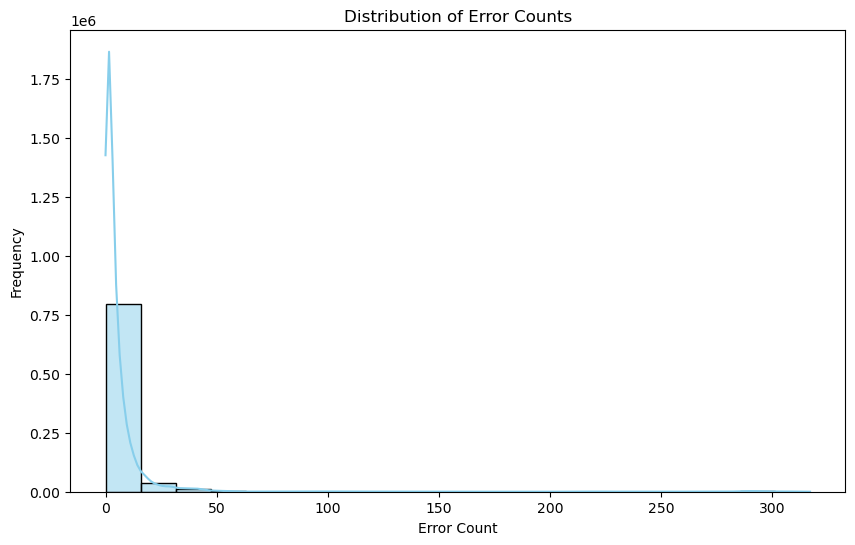

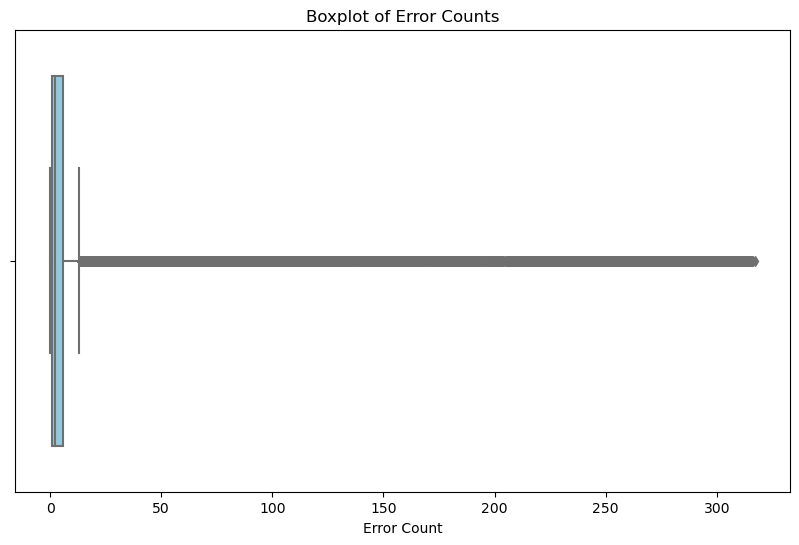

In [70]:
# Plotting the distribution of error counts
plt.figure(figsize=(10, 6))

# Histogram
sns.histplot(df['error_count'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Error Counts')
plt.xlabel('Error Count')
plt.ylabel('Frequency')

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x='error_count', color='skyblue')
plt.title('Boxplot of Error Counts')
plt.xlabel('Error Count')

plt.show()

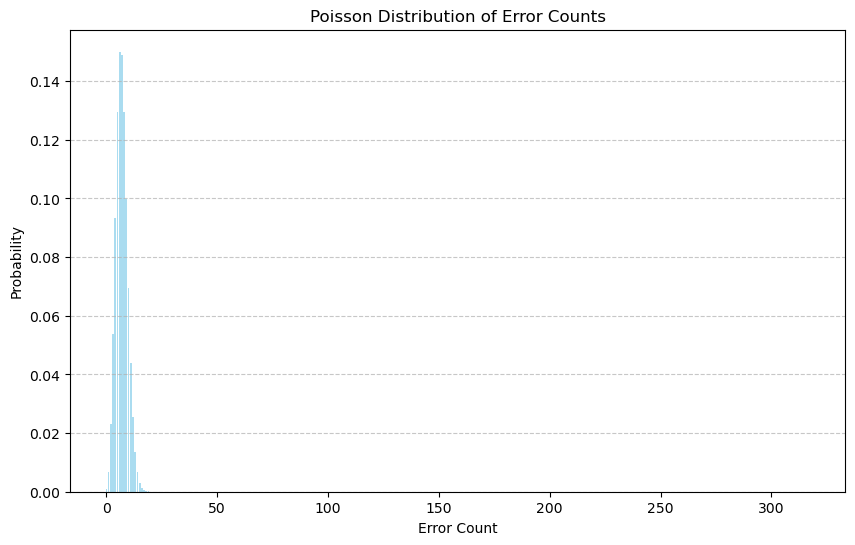

In [69]:
from scipy.stats import poisson
error_counts = df['error_count']

# Calculate the mean of error counts (lambda parameter for Poisson distribution)
mean_error_count = error_counts.mean()

# Generate the Poisson distribution
poisson_dist = poisson(mu=mean_error_count)

# Generate values for x-axis (error counts)
x_values = np.arange(0, error_counts.max() + 1)

# Calculate the probabilities for each error count
probabilities = poisson_dist.pmf(x_values)

# Plot the Poisson distribution
plt.figure(figsize=(10, 6))
plt.bar(x_values, probabilities, color='skyblue', alpha=0.7)
plt.title('Poisson Distribution of Error Counts')
plt.xlabel('Error Count')
plt.ylabel('Probability')
# plt.xticks(x_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Survival Models

Survival estimation can be classified into three main groups: non-parametric, semi parametric, and parametric approaches. Parametric methods depends on the assumptions that survival time correspond to the specific probability distribution. This group consisits of methods such as exponential, Weibull and lognormal distributions. In the non-parametric\ methods there are no dependencies dependent on the underlying distributions. Mostly, the non-parametric approach is used to describe survival probabilities as a function of time and give an average views of the individuals population. Most popular univariate method is the Kaplan-Meier estimator. Cox regression model comes under semi-parametric methods as it depends on parametric as well as non-parametric.

## Kaplan Meier Curve (Time Lapse)

The Kaplan Meier curve is used to graphically represent the survival rate or survival function

In [143]:
df.columns

Index(['message', 'filepath', 'line', 'column', 'kind', 'snippet',
       'end_column', 'file_hash', 'repository', 'commit_hash', 'author_name',
       'author_email', 'committer_name', 'committer_email', 'committed_date',
       'authored_date', 'file_path', 'previous_file_path',
       'previous_file_hash', 'change_type', 'valid_yaml', 'probably_workflow',
       'valid_workflow', 'lines_count', 'commit_year', 'commit_mon_year',
       'next_commit_hash', 'status', 'error_count', 'time_lapse', 'Rule'],
      dtype='object')

In [145]:
df.dtypes

message                object
filepath               object
line                    int64
column                  int64
kind                   object
snippet                object
end_column              int64
file_hash              object
repository             object
commit_hash            object
author_name            object
author_email           object
committer_name         object
committer_email        object
committed_date         object
authored_date           int64
file_path              object
previous_file_path     object
previous_file_hash     object
change_type            object
valid_yaml               bool
probably_workflow        bool
valid_workflow           bool
lines_count             int64
commit_year             int64
commit_mon_year        object
next_commit_hash       object
status                 object
error_count           float64
time_lapse             object
Rule                   object
dtype: object

In [151]:
df['time_lapse'].value_counts()

0 days 00:00:00      32303
407 days 22:59:12     1185
48 days 18:45:56       882
479 days 04:39:29      854
558 days 02:55:54      846
                     ...  
33 days 06:57:42         1
482 days 11:46:11        1
485 days 13:53:29        1
719 days 11:17:47        1
0 days 21:18:55          1
Name: time_lapse, Length: 220780, dtype: int64

In [163]:
def plot_kpl_curve(rules, dataframe):
    for rule in rules:
        if rule == 'Yaml Syntax':
            continue
        df_rule = dataframe[dataframe['Rule'] == rule]  
        df_rule['mapping_time_taken'] = df_rule['time_lapse'].apply(lambda x : False if x == "0 days 00:00:00" else True)
        df_rule['time_taken_delta'] = df_rule['time_lapse'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "0 days 00:00:00" else 0)


        kmf = KaplanMeierFitter()
        kmf.fit(durations=df_rule["time_taken_delta"], event_observed=df_rule["mapping_time_taken"])

        time = kmf.survival_function_.index.values
        survival_prob = kmf.survival_function_.values[:, 0]
        conf_int = kmf.confidence_interval_.values

        plt.step(time, survival_prob, where="post", label=rule)
        plt.fill_between(time, conf_int[:, 0], conf_int[:, 1], alpha=0.25, step="post")
        
        
    plt.ylim(0, 1)
    plt.legend(loc='upper right')
    plt.title("Kaplan Meier Curve for Rules")
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    
    
    
    
def plot_kpl_curve_subplot(rules, dataframe, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    for i, rule in enumerate(rules):
        if rule == 'Yaml Syntax':
            continue
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        
        df_rule = dataframe[dataframe['Rule'] == rule]
        df_rule['mapping_time_taken'] = df_rule['time_lapse'].apply(lambda x : False if x == "0 days 00:00:00" else True)
        df_rule['time_taken_delta'] = df_rule['time_lapse'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "0 days 00:00:00" else 0)

        
        
        kmf = KaplanMeierFitter()
        kmf.fit(durations=df_rule["time_taken_delta"], event_observed=df_rule["mapping_time_taken"])

        time = kmf.survival_function_.index.values
        survival_prob = kmf.survival_function_.values[:, 0]
        conf_int = kmf.confidence_interval_.values
        
        
        ax.step(time, survival_prob, where="post", label=rule)
        ax.fill_between(time, conf_int[:, 0], conf_int[:, 1], alpha=0.25, step="post")
        ax.set_ylim(0, 1)
        ax.legend(loc='upper right')
#         ax.set_title("Kaplan Meier Curve for Rule: " + rule)
        ax.set_ylabel(r"est. probability of survival $\hat{S}(t)$")
        ax.set_xlabel("time $t$")

    plt.tight_layout()
    plt.show()

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_26905/253089814.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rule['mapping_time_taken'] = df_rule['time_lapse'].apply(lambda x : False if x == "0 days 00:00:00" else True)
/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_26905/253089814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rule['time_taken_delta'] = df_rule['time_lapse'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "0 days 

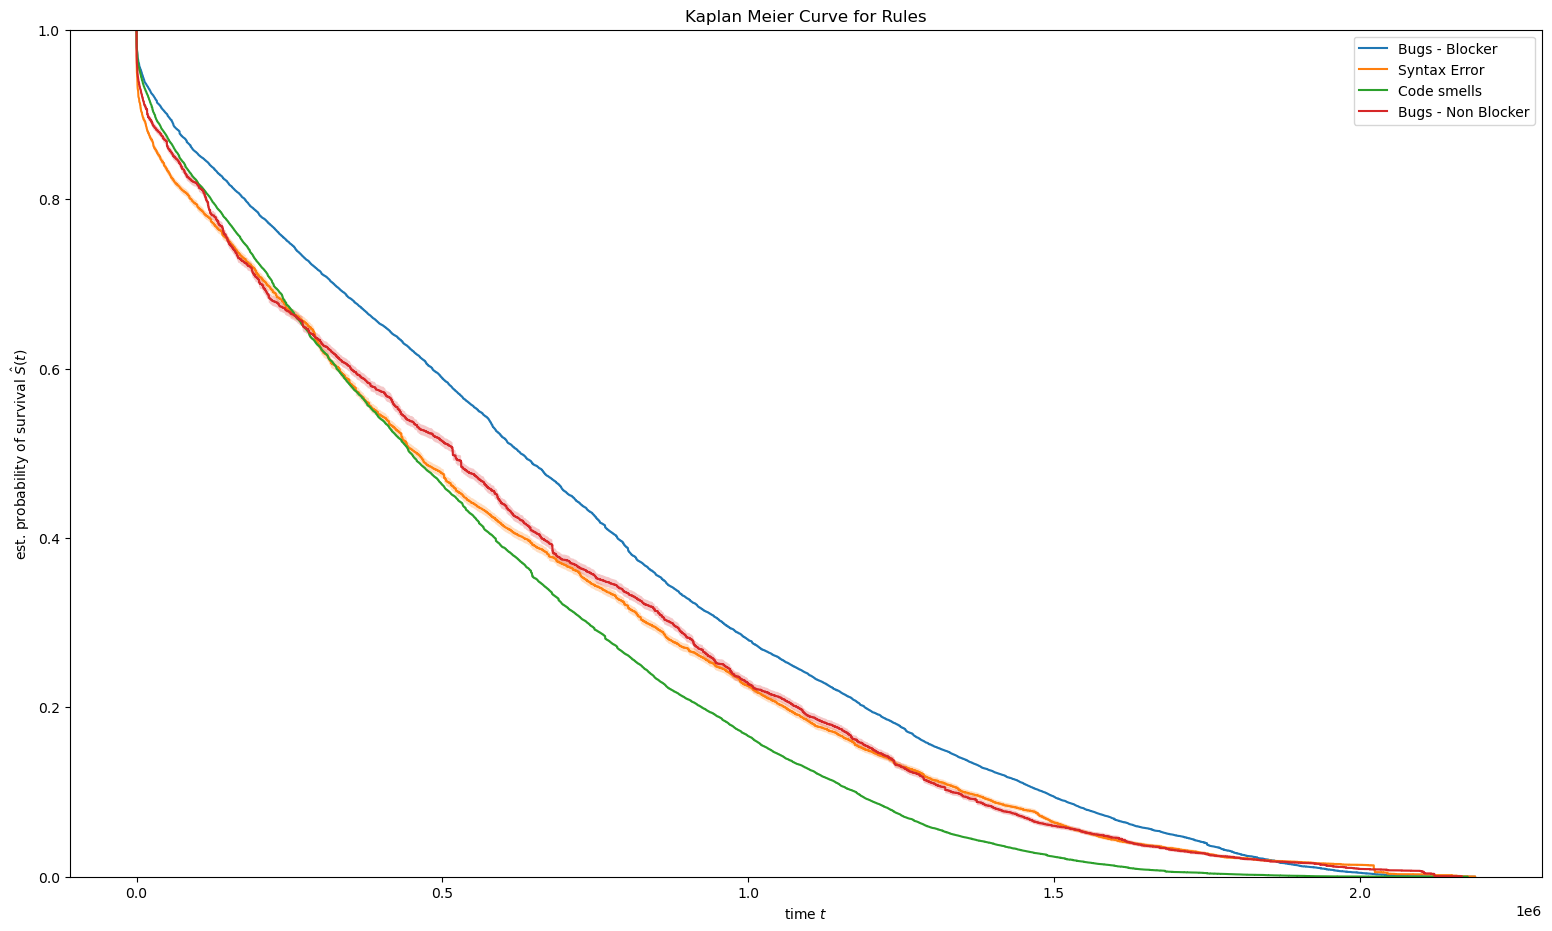

In [164]:
plot_kpl_curve(df['Rule'].unique() ,df)

The above plot shows the probabilty of the survival of the code quality issue based on the time lapse. Bug - Blocker can exist for the more time than the other code quality issue and whereas code smells has the lowest probablity of the survival.

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_26905/4207935055.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rule['mapping_time_taken'] = df_rule['time_lapse'].apply(lambda x : False if x == "0 days 00:00:00" else True)
/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_26905/4207935055.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rule['time_taken_delta'] = df_rule['time_lapse'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "0 d

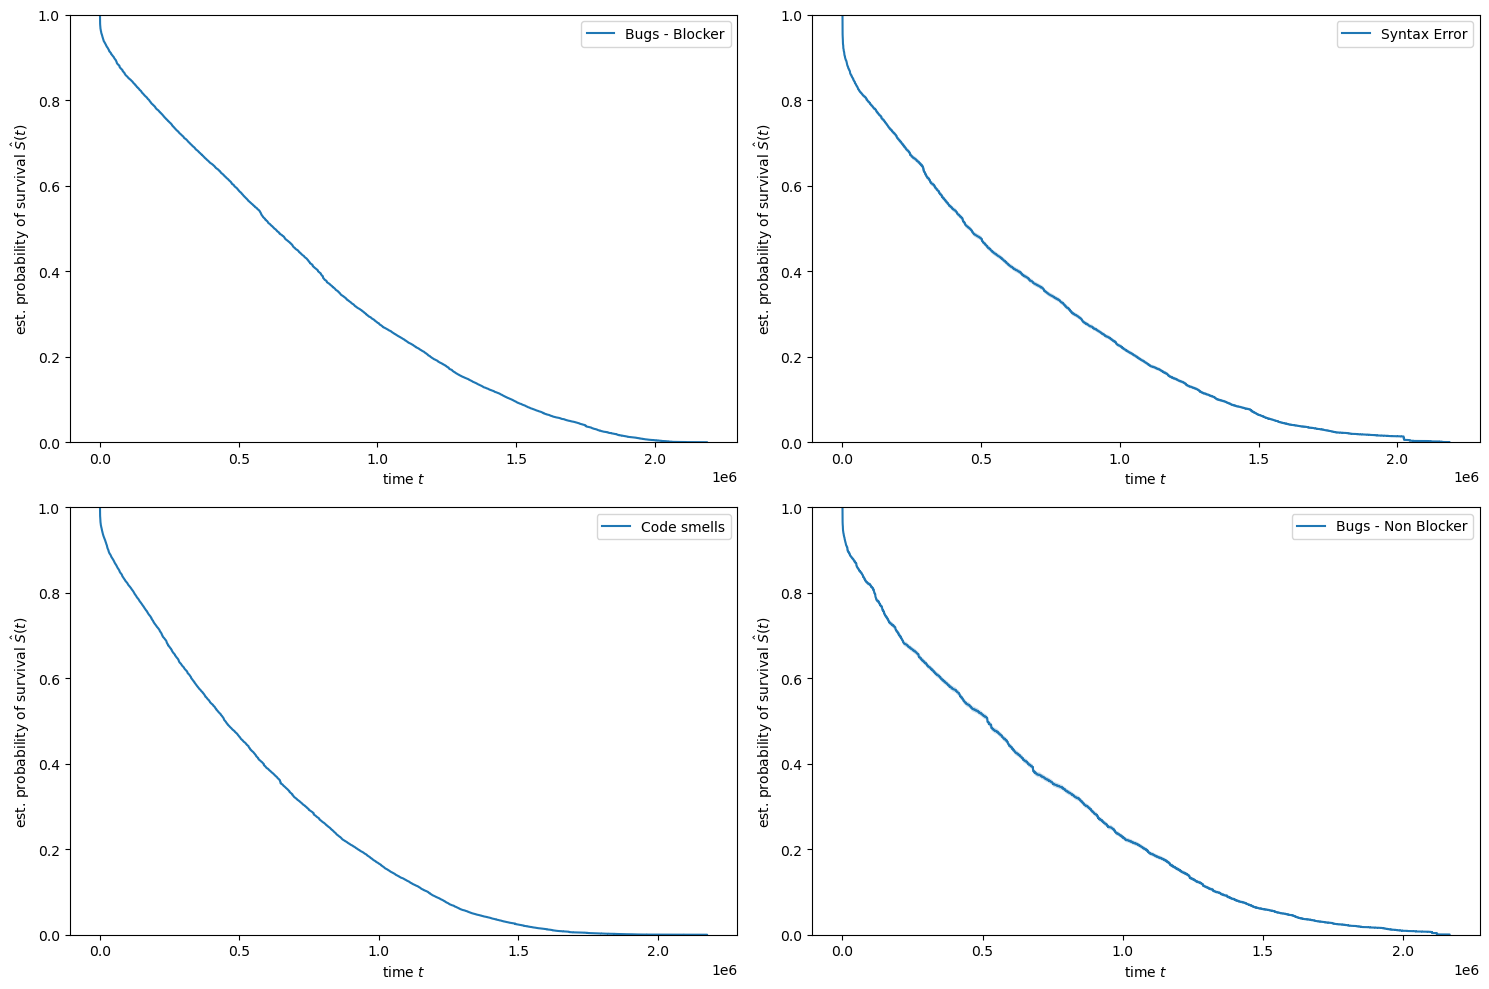

In [162]:
plot_kpl_curve_subplot(df['Rule'].unique(), df, 2, 2)

The above plot shows the probability the survival decreases with the increase of the time lapse

## Kaplan Meier Curve (Error Count)

In [165]:
df['error_count'].value_counts()

1.0      199651
2.0      125673
0.0      114232
3.0       79789
4.0       58638
          ...  
316.0         5
183.0         5
206.0         5
205.0         5
317.0         1
Name: error_count, Length: 318, dtype: int64

In [187]:
def plot_kpl_curve_error_count(rules, dataframe):
    for rule in rules:
        if rule == 'Yaml Syntax':
            continue
        df_rule = dataframe[dataframe['Rule'] == rule]  
        df_rule['mapping_error_count'] = df_rule['error_count'].apply(lambda x : False if x == 0.0 else True)
#         df_rule['time_taken_delta'] = df_rule['time_lapse'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "0 days 00:00:00" else 0)


        kmf = KaplanMeierFitter()
        kmf.fit(durations=df_rule["error_count"], event_observed=df_rule["mapping_error_count"])

        time = kmf.survival_function_.index.values
        survival_prob = kmf.survival_function_.values[:, 0]
        conf_int = kmf.confidence_interval_.values

        plt.step(time, survival_prob, where="post", label=rule)
        plt.fill_between(time, conf_int[:, 0], conf_int[:, 1], alpha=0.25, step="post")
        
        
    plt.ylim(0, 1)
#     plt.xlim(0,5)
#     plt.xticks(1,100)
    plt.legend(loc='upper right')
    plt.title("Kaplan Meier Curve for Rules")
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("error count")
    
    
    
    
def plot_kpl_curve_subplot_error_count(rules, dataframe, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    for i, rule in enumerate(rules):
        if rule == 'Yaml Syntax':
            continue
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        
        df_rule = dataframe[dataframe['Rule'] == rule]
        df_rule['mapping_error_count'] = df_rule['error_count'].apply(lambda x : False if x == 0.0 else True)
#         df_rule['time_taken_delta'] = df_rule['time_lapse'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "0 days 00:00:00" else 0)

        
        
        kmf = KaplanMeierFitter()
        kmf.fit(durations=df_rule["error_count"], event_observed=df_rule["mapping_error_count"])

        time = kmf.survival_function_.index.values
        survival_prob = kmf.survival_function_.values[:, 0]
        conf_int = kmf.confidence_interval_.values
        
        
        ax.step(time, survival_prob, where="post", label=rule)
        ax.fill_between(time, conf_int[:, 0], conf_int[:, 1], alpha=0.25, step="post")
        ax.set_ylim(0, 1)
        ax.legend(loc='upper right')
        ax.set_title("Kaplan Meier Curve for Rule: " + rule)
        ax.set_ylabel(r"est. probability of survival $\hat{S}(t)$")
        ax.set_xlabel("error count")

    plt.tight_layout()
    plt.show()

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_26905/2388338503.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rule['mapping_time_taken'] = df_rule['error_count'].apply(lambda x : False if x == 0.0 else True)
/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_26905/2388338503.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rule['mapping_time_taken'] = df_rule['error_count'].apply(lambda x : False if x == 0.0 else True)
/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipyke

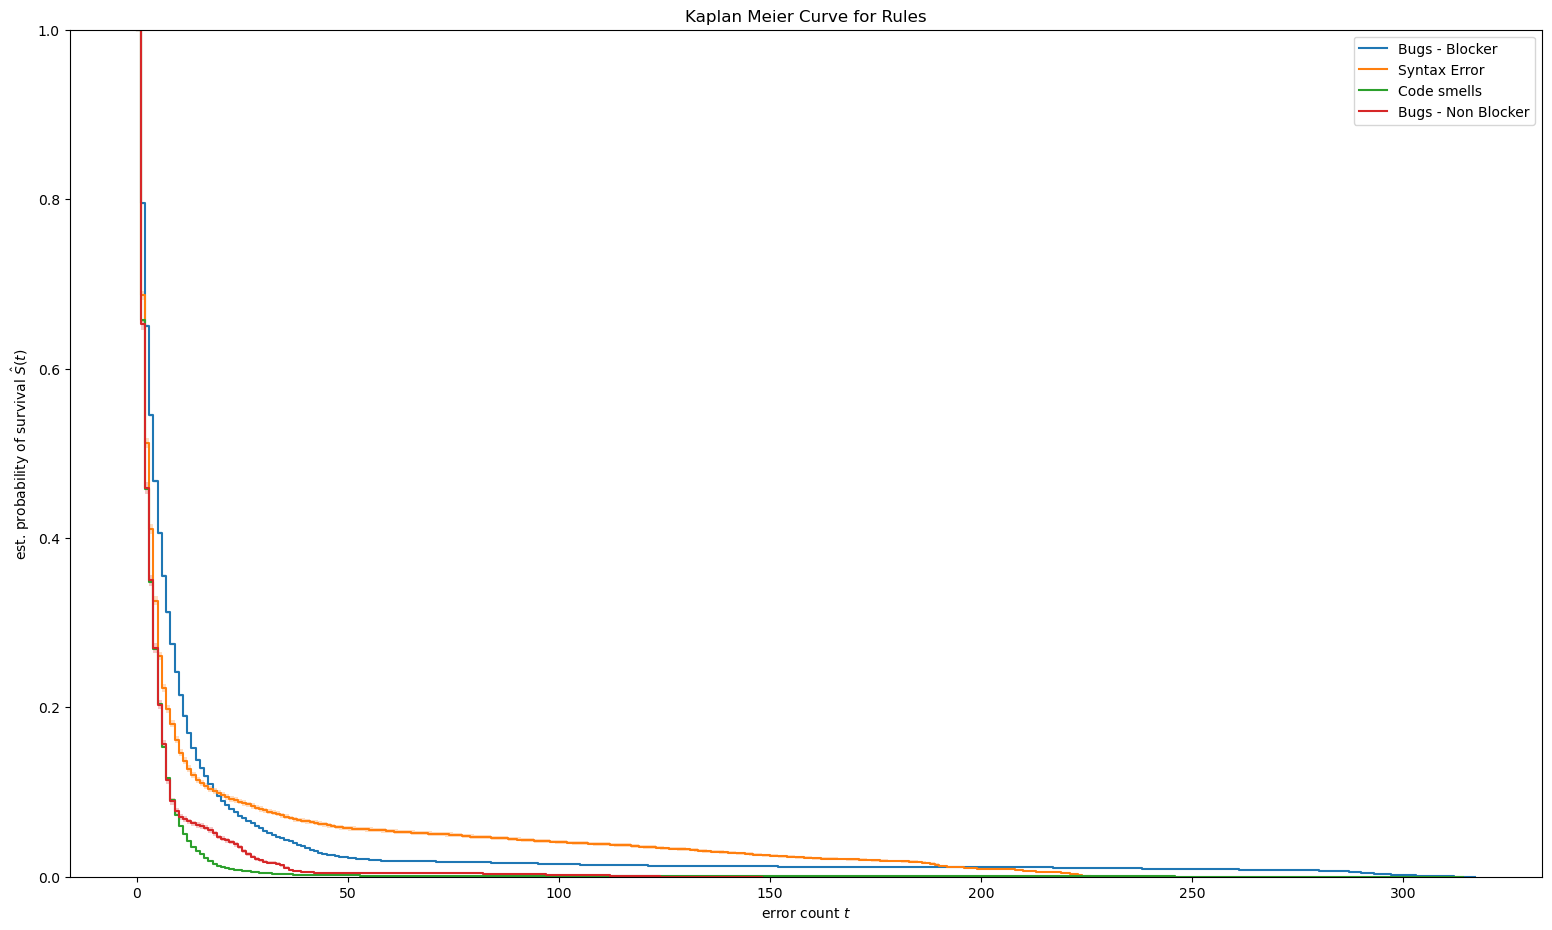

In [182]:
plot_kpl_curve_error_count(df['Rule'].unique() ,df)

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_26905/3359530073.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rule['mapping_error_count'] = df_rule['error_count'].apply(lambda x : False if x == 0.0 else True)
/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_26905/3359530073.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rule['mapping_error_count'] = df_rule['error_count'].apply(lambda x : False if x == 0.0 else True)
/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/i

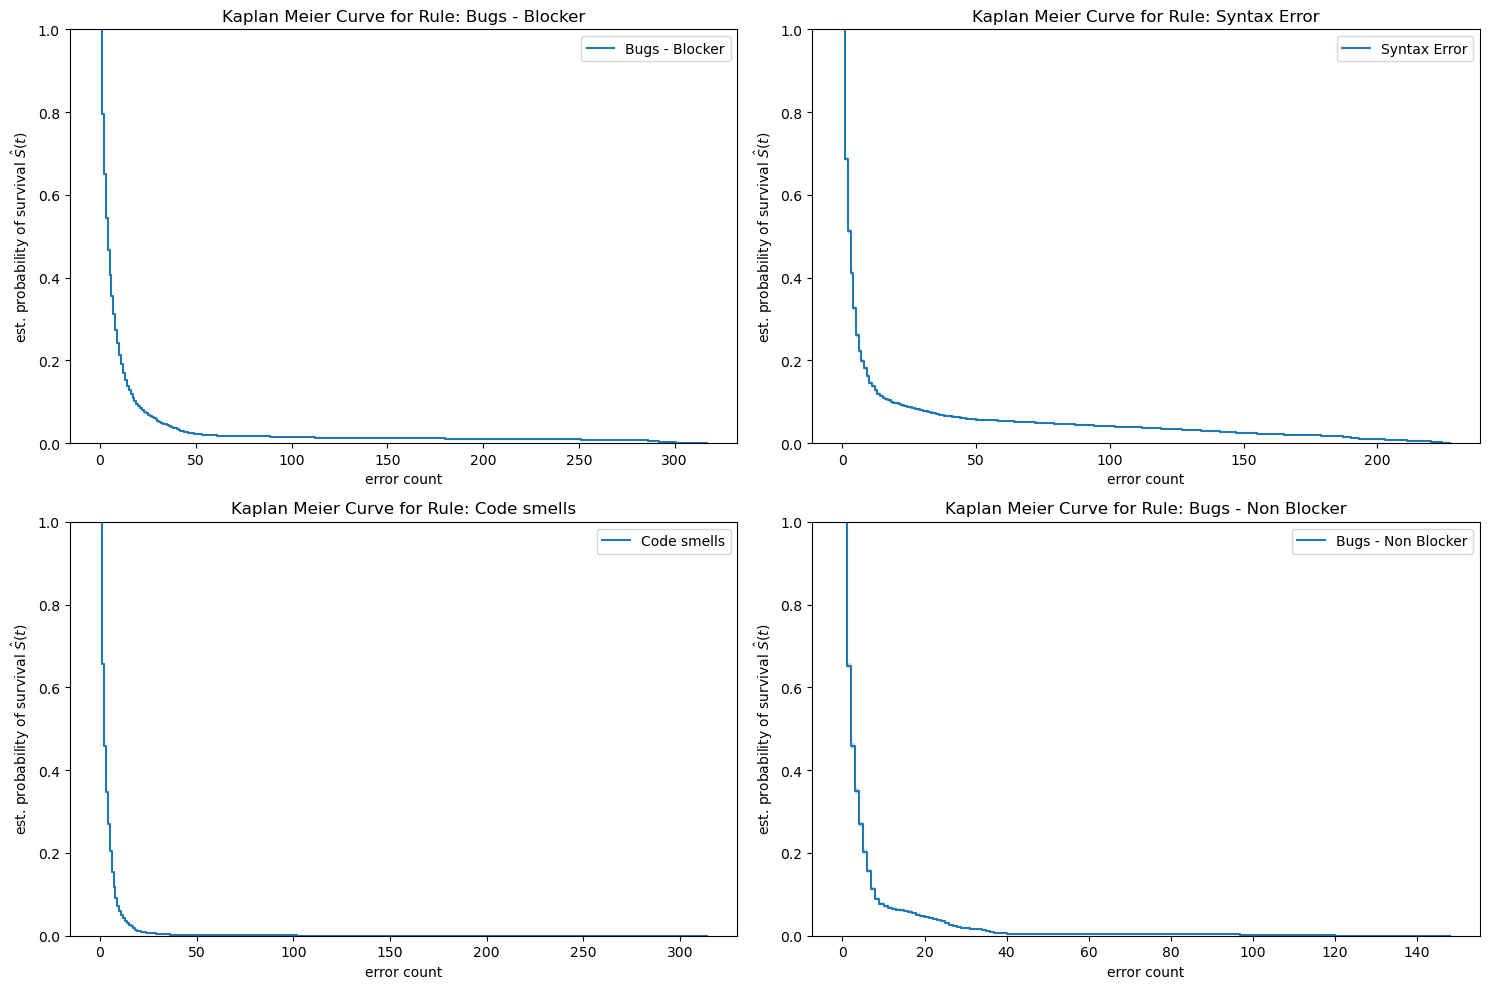

In [188]:
plot_kpl_curve_subplot_error_count(df['Rule'].unique() ,df, 2, 2)